In [1]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

In [2]:
def find_distracted (students):
        
    var_o_var = []
    for s in students:
        
        nt = students [s] ['df'].values [33].tolist()
        ntx = nt [0::2]
        mean = np.mean (ntx)
        sigma = np.std (ntx)
        sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])

        var_o_var.append (sigmanorm)
        
    sigma_s = np.std (var_o_var)
    
    mean_s = np.mean (var_o_var)
    
    disturbed = []
    print ("threshold: ", mean_s + sigma_s)
    for i in range (len (var_o_var)):
        print (var_o_var [i])
        if var_o_var [i] > mean_s + sigma_s:
            disturbed.append ((i+1))
            
    return disturbed
        
    

In [3]:
def plot_movement (studs):
    
    nt = students [s] ['df'].values [33].tolist()
    ntx = nt [0::2]
    nty = nt [1::2]
    
    plt.plot (ntx, nty)
    

In [10]:
find_distracted (students)

threshold:  0.22405389122941693
0.032442931553863616
0.22366324545991528
0.17328177364417868


[]

In [4]:
def find_face1 (x1,y1,stu):
    
    maxx = 0.0
    maxy = 0.0
    sdnt = ''
    flag = 0
    
    for s in stu:
        temp1 = norm.pdf (x1, np.mean (stu [s] ['x1']), stu [s]['sd'])
        temp2 = norm.pdf (y1 ,np.mean (stu [s] ['y1']), stu [s]['sd'])
        if (temp1 > maxx and temp1 > 0.00000001):
            maxx = temp1
            if(temp2 > maxy and temp2 > 0.00000001):
                maxy = temp2
                sdnt = s
                flag = 1
            
    if (flag == 0):
        stu [len (stu) + 1] = {'x1': [x1],'y1':[y1], 'df':pd.DataFrame (), 'sd': 10}
        return (len (stu), stu)
    
    stu [sdnt] ['x1'].append (x1)
    stu [sdnt] ['y1'].append (y1)
    return (sdnt, stu)

In [3]:
def find_face2 (x1, y1 , stu):
    
    max = 0.0
    sdnt = ''
    flag = 0
    
    for s in stu:
        temp = norm.pdf (x1, np.mean (stu [s] ['x1']), stu [s]['sd'])
        if (temp > max and temp > 0.00000001):
            max = temp
            sdnt = s
            flag = 1
            
    if (flag == 0):
        stu [len (stu) + 1] = {'x1': [x1],'y1':[y1], 'df':pd.DataFrame (), 'sd': 10}
        return (len (stu), stu)
    
    stu [sdnt] ['x1'].append (x1)
    stu [sdnt] ['y1'].append (y1)
    return (sdnt, stu)

In [5]:
df = pd.DataFrame()
students = {}
distracted = []

cap = cv2.VideoCapture(0)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

for i in range(300):
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    
    for face in faces:
        
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        #cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
        
        #f, students = find_face (x1, x2, students)
        f, students = find_face1(x1, y1, students)
        #f, students = find_face2(x1, y1, students)
        
        print ("student (f): ", f)
        print ("distracted: ", distracted)
        if f in distracted:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
        else:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
        print (x1, "  ", x2)
        landmarks = predictor(gray, face)
        xc = []
        yc = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            xc.append(x)
            yc.append(y)
            cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)
            
        students [f] ['df'] ['x'+str(i)] = xc
        students [f] ['df'] ['y'+str(i)] = yc
        students [f] ['box'] = list ((x1, x2))
    
    cv2.imshow("Frame", frame)
    print (len (students))
    
    distracted = find_distracted (students)
    

    key = cv2.waitKey(1)
    if key == 27:
        break
        
cap.release ()
cv2.destroyAllWindows ()

0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan


/home/ankit/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ankit/.local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ankit/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ankit/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ankit/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
0
threshold:  nan
student (f):  1
distracted:  []
300    424
1
threshold:  0.0
0.0
student (f):  1
distracted:  []
300    424
1
threshold:  0.0
0.0
student (f):  1
distracted:  []
300    424
1
threshold:  0.0038016493612179976
0.0038016493612179976
student (f):  1
distracted:  []
300    424
1
threshold:  0.0034920379184856395
0.0034920379184856395
student (f):  1
distracted:  []
300    424
1
threshold:  0.0032258064516129032
0.0032258064516129032
student (f):  1
distracted:  []
300    424
1
threshold:  0.0030054677116932663
0.0030054677116932663
student (f):  1
distracted:  []
30

student (f):  1
distracted:  []
300    424
1
threshold:  0.13582738000104744
0.13582738000104744
student (f):  1
distracted:  []
307    411
1
threshold:  0.16102898937016125
0.16102898937016125
student (f):  1
distracted:  []
307    411
1
threshold:  0.16006425554719061
0.16006425554719061
student (f):  1
distracted:  []
307    411
1
threshold:  0.15906553492987255
0.15906553492987255
student (f):  1
distracted:  []
300    424
1
threshold:  0.13252483505572335
0.13252483505572335
student (f):  1
distracted:  []
300    424
1
threshold:  0.1316571897985488
0.1316571897985488
student (f):  1
distracted:  []
300    424
1
threshold:  0.1307861082938084
0.1307861082938084
student (f):  1
distracted:  []
300    424
1
threshold:  0.12991214335146764
0.12991214335146764
student (f):  1
distracted:  []
300    424
1
threshold:  0.12905542436517414
0.12905542436517414
1
threshold:  0.12905542436517414
0.12905542436517414
student (f):  1
distracted:  []
300    424
1
threshold:  0.12822185031551533


student (f):  1
distracted:  []
300    424
1
threshold:  0.09242627082572945
0.09242627082572945
student (f):  1
distracted:  []
300    424
1
threshold:  0.0921328872691749
0.0921328872691749
student (f):  1
distracted:  []
300    424
1
threshold:  0.09184227462786847
0.09184227462786847
student (f):  1
distracted:  []
300    424
1
threshold:  0.09156662450804129
0.09156662450804129
student (f):  1
distracted:  []
300    424
1
threshold:  0.09128132008204425
0.09128132008204425
student (f):  1
distracted:  []
300    424
1
threshold:  0.09099866124007658
0.09099866124007658
student (f):  1
distracted:  []
300    424
1
threshold:  0.0907186074254257
0.0907186074254257
1
threshold:  0.0907186074254257
0.0907186074254257
student (f):  1
distracted:  []
300    424
1
threshold:  0.09043384524483213
0.09043384524483213
student (f):  1
distracted:  []
300    424
1
threshold:  0.09015174757728937
0.09015174757728937
student (f):  1
distracted:  []
300    424
1
threshold:  0.08986960179237605
0.

In [13]:
cap = cv2.VideoCapture(0)

for i in range (50):
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.rectangle (frame, (0, 0), (300, 350), (255, 0, 0), 3)
    cv2.imshow("Frame", frame)
    
    key = cv2.waitKey(1)
    if key == 27:
        break
    
cap.release ()
cv2.destroyAllWindows ()

In [12]:
def scaling:
    

SyntaxError: invalid syntax (<ipython-input-12-a760616ac932>, line 1)

In [6]:
len (students)


1

In [49]:
cap.release ()
cv2.destroyAllWindows ()

In [ ]:
students

In [7]:
for s in students:
    
    print (students [s] ['box'])

[286, 411]


1
[328, 329, 329, 330, 330, 332, 333, 334, 334, 335, 335, 336, 336, 339, 341, 343, 345, 345, 345, 345, 347, 347, 348, 349, 350, 351, 351, 352, 352, 355, 356, 356, 357, 357, 357, 357, 358, 358, 358, 358, 359, 360, 360, 360, 361, 362, 362, 362, 362, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 36

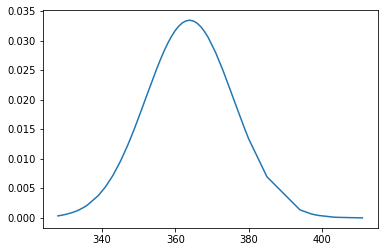

In [8]:
for s in students:
    
    nt = students [s] ['df'].values [33].tolist()
    ntx = nt [0::2]
    ntx.sort()
    mean = np.mean (ntx)
    sigma = np.std (ntx)
    sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])
    #plt.ylim ((0, 1))
    plt.plot (ntx, norm.pdf (ntx, mean, sigma))
    #plt.show ()
    print (s)
    print (ntx)
    print (students [s]['box'][1] - students[s]['box'][0])
    print (sigma)
    print (sigmanorm)

plt.show ()

In [9]:
for s in students:
    
    print (students [s] ['box'])

[286, 411]


In [10]:
find_distracted (students)

threshold:  0.09536741854163075
0.09536741854163075


[]

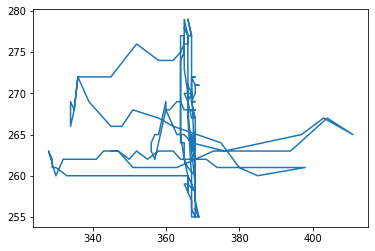

In [11]:
plot_movement (students)

In [ ]:
cap.release ()
cv2.destroyAllWindows ()

In [ ]:
norm.pdf (350, 450, 15)

In [ ]:
students [1] ['df']